In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [ ]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothbuildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

# rearranging columns
#df = df[['oat', 'orh', 'sat', 'Ghi', 'flow', 'totale']]

In [6]:
df.head()

,oat,orh,sat,hwe,cwe,totale,Ghi,flow
2018-07-12 13:55:00,89.554909,76.0,75.443275,0.0,35.590466,35.590466,872.0,43.108143
2018-07-12 14:00:00,89.863190,76.0,75.443275,0.0,33.027813,33.027813,866.0,45.760704
2018-07-12 14:05:00,89.863190,76.0,75.443275,0.0,31.769627,31.769627,859.0,45.840881
2018-07-12 14:10:00,90.484146,69.0,75.443275,0.0,34.195641,34.195641,848.0,43.372566
2018-07-12 14:15:00,90.826981,69.0,75.443275,0.0,31.082222,31.082222,836.0,38.218956


In [7]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.15
)

Finished 'dataframeplot' in 0.5696 secs


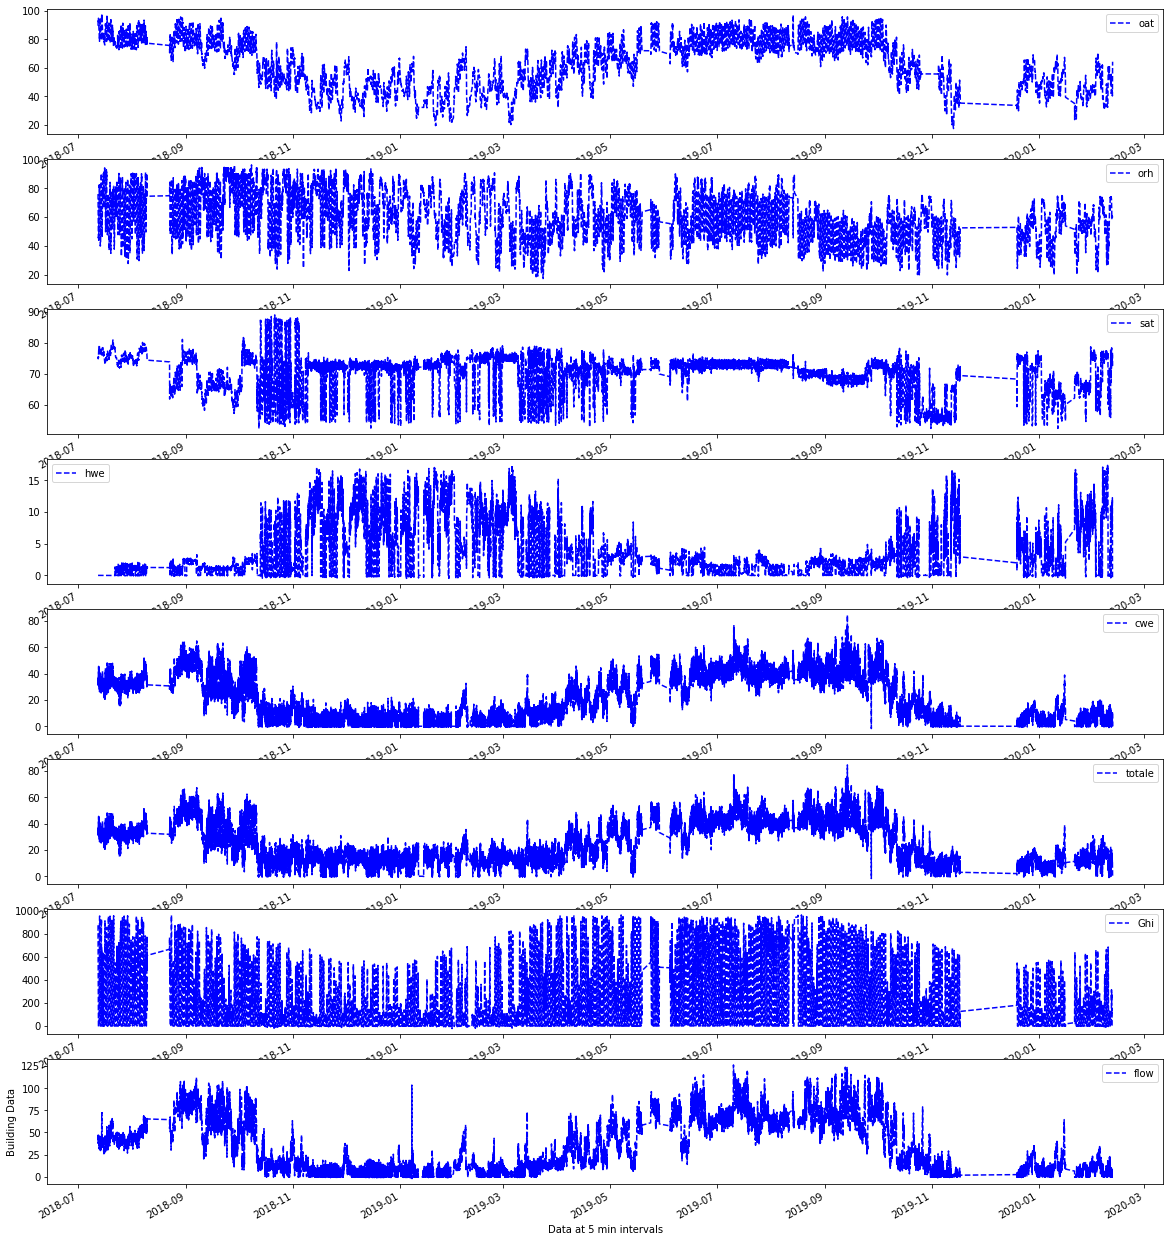

In [8]:
dp.dataframeplot(df=df_smoothed,
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [9]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df_smoothed, subsequence=True, period=1, days=7, hours=0)

In [10]:
len(dflist)

10

In [11]:
# dflist = [df]

In [11]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'Ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [12]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [13]:
path = '../results/lstm3/'
!rm -rf ../results/lstm3

In [14]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [15]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [16]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 16,
    'lstm_no_layers': 4,
    'dense_hidden_units':16,
    'dense_no_layers': 4
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=400, initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno)

  0%|          | 0/10 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/400
 - 4s - loss: 0.1801 - val_loss: 0.0898
Epoch 2/400
 - 1s - loss: 0.0651 - val_loss: 0.0375
Epoch 3/400
 - 1s - loss: 0.0478 - val_loss: 0.0377
Epoch 4/400
 - 1s - loss: 0.0455 - val_loss: 0.0354
Epoch 5/400
 - 1s - loss: 0.0427 - val_loss: 0.0330
Epoch 6/400
 - 1s - loss: 0.0393 - val_loss: 0.0324
Epoch 7/400
 - 1s - loss: 0.0376 - val_loss: 0.0320
Epoch 8/400
 - 1s - loss: 0.0364 - val_loss: 0.0314
Epoch 9/400
 - 1s - loss: 0.0353 - val_loss: 0.0306
Epoch 10/400
 - 1s - loss: 0.0342 - val_loss: 0.0300
Epoch 11/400
 - 1s - loss: 0.0332 - val_loss: 0.0295
Epoch 12/400
 - 1s - loss: 0.0321 - val_loss: 0.0288
Epoch 13/400
 - 1s - loss: 0.0311 - val_loss: 0.0283
Epoch 14/400
 - 1s - loss: 0.0301 - val_loss: 0.0278
Epoch 15/400
 - 1s - loss: 0.0290 - val_loss: 0.0273
Epoch 16/400
 - 1s - loss: 0.0284 - val_loss: 0.0268
Epoch 17/400
 

 10%|█         | 1/10 [02:30<22:37, 150.83s/it]

Train on 1511 samples, validate on 504 samples
Epoch 45/400
 - 4s - loss: 0.3043 - val_loss: 0.0189
Epoch 46/400
 - 1s - loss: 0.0757 - val_loss: 0.0932
Epoch 47/400
 - 1s - loss: 0.0448 - val_loss: 0.1206
Epoch 48/400
 - 1s - loss: 0.0325 - val_loss: 0.1327
Epoch 49/400
 - 1s - loss: 0.0299 - val_loss: 0.1465
Epoch 50/400
 - 1s - loss: 0.0281 - val_loss: 0.1562
Epoch 51/400
 - 1s - loss: 0.0273 - val_loss: 0.1624
Epoch 52/400
 - 1s - loss: 0.0258 - val_loss: 0.1629
Epoch 53/400
 - 1s - loss: 0.0258 - val_loss: 0.1634


 20%|██        | 2/10 [03:30<16:26, 123.34s/it]

Train on 1511 samples, validate on 504 samples
Epoch 54/400
 - 4s - loss: 0.2091 - val_loss: 0.0534
Epoch 55/400
 - 1s - loss: 0.0870 - val_loss: 0.0265
Epoch 56/400
 - 1s - loss: 0.0737 - val_loss: 0.0231
Epoch 57/400
 - 1s - loss: 0.0666 - val_loss: 0.0226
Epoch 58/400
 - 1s - loss: 0.0653 - val_loss: 0.0220
Epoch 59/400
 - 1s - loss: 0.0634 - val_loss: 0.0220
Epoch 60/400
 - 1s - loss: 0.0636 - val_loss: 0.0205
Epoch 61/400
 - 1s - loss: 0.0593 - val_loss: 0.0202
Epoch 62/400
 - 1s - loss: 0.0575 - val_loss: 0.0199
Epoch 63/400
 - 1s - loss: 0.0548 - val_loss: 0.0201
Epoch 64/400
 - 1s - loss: 0.0524 - val_loss: 0.0198
Epoch 65/400
 - 1s - loss: 0.0459 - val_loss: 0.0189
Epoch 66/400
 - 1s - loss: 0.0426 - val_loss: 0.0186
Epoch 67/400
 - 1s - loss: 0.0402 - val_loss: 0.0187
Epoch 68/400
 - 1s - loss: 0.0387 - val_loss: 0.0191
Epoch 69/400
 - 1s - loss: 0.0368 - val_loss: 0.0192
Epoch 70/400
 - 1s - loss: 0.0367 - val_loss: 0.0192
Epoch 71/400
 - 1s - loss: 0.0366 - val_loss: 0.0193

 30%|███       | 3/10 [05:01<13:17, 113.91s/it]

Train on 1511 samples, validate on 504 samples
Epoch 75/400
 - 4s - loss: 0.1979 - val_loss: 0.0457
Epoch 76/400
 - 1s - loss: 0.0486 - val_loss: 0.0451
Epoch 77/400
 - 1s - loss: 0.0493 - val_loss: 0.0438
Epoch 78/400
 - 1s - loss: 0.0462 - val_loss: 0.0424
Epoch 79/400
 - 1s - loss: 0.0431 - val_loss: 0.0412
Epoch 80/400
 - 1s - loss: 0.0412 - val_loss: 0.0401
Epoch 81/400
 - 1s - loss: 0.0394 - val_loss: 0.0389
Epoch 82/400
 - 1s - loss: 0.0372 - val_loss: 0.0375
Epoch 83/400
 - 1s - loss: 0.0344 - val_loss: 0.0358
Epoch 84/400
 - 1s - loss: 0.0309 - val_loss: 0.0342
Epoch 85/400
 - 1s - loss: 0.0272 - val_loss: 0.0330
Epoch 86/400
 - 1s - loss: 0.0243 - val_loss: 0.0325
Epoch 87/400
 - 1s - loss: 0.0228 - val_loss: 0.0324
Epoch 88/400
 - 1s - loss: 0.0221 - val_loss: 0.0323
Epoch 89/400
 - 1s - loss: 0.0217 - val_loss: 0.0322
Epoch 90/400
 - 1s - loss: 0.0213 - val_loss: 0.0320
Epoch 91/400
 - 1s - loss: 0.0210 - val_loss: 0.0318
Epoch 92/400
 - 1s - loss: 0.0208 - val_loss: 0.0317

 40%|████      | 4/10 [08:57<15:02, 150.38s/it]

Train on 1511 samples, validate on 504 samples
Epoch 151/400
 - 4s - loss: 0.0408 - val_loss: 0.0547
Epoch 152/400
 - 1s - loss: 0.0297 - val_loss: 0.0597
Epoch 153/400
 - 1s - loss: 0.0283 - val_loss: 0.0608
Epoch 154/400
 - 1s - loss: 0.0258 - val_loss: 0.0662
Epoch 155/400
 - 1s - loss: 0.0243 - val_loss: 0.0702
Epoch 156/400
 - 1s - loss: 0.0236 - val_loss: 0.0725
Epoch 157/400
 - 1s - loss: 0.0232 - val_loss: 0.0737
Epoch 158/400
 - 1s - loss: 0.0227 - val_loss: 0.0738
Epoch 159/400
 - 1s - loss: 0.0227 - val_loss: 0.0740


 50%|█████     | 5/10 [09:58<10:17, 123.58s/it]

Train on 1511 samples, validate on 504 samples
Epoch 160/400
 - 4s - loss: 0.1815 - val_loss: 0.0406
Epoch 161/400
 - 1s - loss: 0.0536 - val_loss: 0.0488
Epoch 162/400
 - 1s - loss: 0.0383 - val_loss: 0.0366
Epoch 163/400
 - 1s - loss: 0.0359 - val_loss: 0.0319
Epoch 164/400
 - 1s - loss: 0.0332 - val_loss: 0.0279
Epoch 165/400
 - 1s - loss: 0.0318 - val_loss: 0.0258
Epoch 166/400
 - 1s - loss: 0.0310 - val_loss: 0.0253
Epoch 167/400
 - 1s - loss: 0.0302 - val_loss: 0.0254
Epoch 168/400
 - 1s - loss: 0.0295 - val_loss: 0.0260
Epoch 169/400
 - 1s - loss: 0.0241 - val_loss: 0.0273
Epoch 170/400
 - 1s - loss: 0.0239 - val_loss: 0.0281
Epoch 171/400
 - 1s - loss: 0.0238 - val_loss: 0.0285
Epoch 172/400
 - 1s - loss: 0.0237 - val_loss: 0.0287
Epoch 173/400
 - 1s - loss: 0.0232 - val_loss: 0.0288
Epoch 174/400
 - 1s - loss: 0.0232 - val_loss: 0.0288


 60%|██████    | 6/10 [11:14<07:17, 109.44s/it]

Train on 1511 samples, validate on 504 samples
Epoch 175/400
 - 5s - loss: 0.1963 - val_loss: 0.1323
Epoch 176/400
 - 1s - loss: 0.0506 - val_loss: 0.0708
Epoch 177/400
 - 1s - loss: 0.0471 - val_loss: 0.0617
Epoch 178/400
 - 1s - loss: 0.0420 - val_loss: 0.0577
Epoch 179/400
 - 1s - loss: 0.0400 - val_loss: 0.0532
Epoch 180/400
 - 1s - loss: 0.0388 - val_loss: 0.0490
Epoch 181/400
 - 1s - loss: 0.0380 - val_loss: 0.0443
Epoch 182/400
 - 1s - loss: 0.0370 - val_loss: 0.0412
Epoch 183/400
 - 1s - loss: 0.0365 - val_loss: 0.0388
Epoch 184/400
 - 1s - loss: 0.0359 - val_loss: 0.0374
Epoch 185/400
 - 1s - loss: 0.0353 - val_loss: 0.0363
Epoch 186/400
 - 1s - loss: 0.0348 - val_loss: 0.0353
Epoch 187/400
 - 1s - loss: 0.0342 - val_loss: 0.0343
Epoch 188/400
 - 1s - loss: 0.0337 - val_loss: 0.0333
Epoch 189/400
 - 1s - loss: 0.0331 - val_loss: 0.0322
Epoch 190/400
 - 1s - loss: 0.0324 - val_loss: 0.0310
Epoch 191/400
 - 1s - loss: 0.0317 - val_loss: 0.0301
Epoch 192/400
 - 1s - loss: 0.0310 

 70%|███████   | 7/10 [13:17<05:40, 113.35s/it]

Train on 1511 samples, validate on 504 samples
Epoch 207/400
 - 4s - loss: 0.1012 - val_loss: 0.0235
Epoch 208/400
 - 1s - loss: 0.0317 - val_loss: 0.0264
Epoch 209/400
 - 1s - loss: 0.0261 - val_loss: 0.0219
Epoch 210/400
 - 1s - loss: 0.0205 - val_loss: 0.0145
Epoch 211/400
 - 1s - loss: 0.0190 - val_loss: 0.0146
Epoch 212/400
 - 1s - loss: 0.0187 - val_loss: 0.0142
Epoch 213/400
 - 1s - loss: 0.0183 - val_loss: 0.0139
Epoch 214/400
 - 1s - loss: 0.0179 - val_loss: 0.0136
Epoch 215/400
 - 1s - loss: 0.0175 - val_loss: 0.0132
Epoch 216/400
 - 1s - loss: 0.0171 - val_loss: 0.0128
Epoch 217/400
 - 1s - loss: 0.0166 - val_loss: 0.0124
Epoch 218/400
 - 1s - loss: 0.0162 - val_loss: 0.0119
Epoch 219/400
 - 1s - loss: 0.0156 - val_loss: 0.0115
Epoch 220/400
 - 1s - loss: 0.0151 - val_loss: 0.0110
Epoch 221/400
 - 1s - loss: 0.0145 - val_loss: 0.0106
Epoch 222/400
 - 1s - loss: 0.0139 - val_loss: 0.0103
Epoch 223/400
 - 1s - loss: 0.0135 - val_loss: 0.0101
Epoch 224/400
 - 1s - loss: 0.0130 

 80%|████████  | 8/10 [15:10<03:46, 113.39s/it]

Train on 1511 samples, validate on 504 samples
Epoch 236/400
 - 5s - loss: 0.2004 - val_loss: 0.0124
Epoch 237/400
 - 1s - loss: 0.0257 - val_loss: 0.0127
Epoch 238/400
 - 1s - loss: 0.0252 - val_loss: 0.0124
Epoch 239/400
 - 1s - loss: 0.0267 - val_loss: 0.0099
Epoch 240/400
 - 1s - loss: 0.0206 - val_loss: 0.0110
Epoch 241/400
 - 1s - loss: 0.0190 - val_loss: 0.0118
Epoch 242/400
 - 1s - loss: 0.0186 - val_loss: 0.0121
Epoch 243/400
 - 1s - loss: 0.0179 - val_loss: 0.0122
Epoch 244/400
 - 1s - loss: 0.0179 - val_loss: 0.0123
Epoch 245/400
 - 1s - loss: 0.0178 - val_loss: 0.0123
Epoch 246/400
 - 1s - loss: 0.0178 - val_loss: 0.0124
Epoch 247/400
 - 1s - loss: 0.0177 - val_loss: 0.0124


 90%|█████████ | 9/10 [16:19<01:39, 99.93s/it] 

Train on 1511 samples, validate on 504 samples
Epoch 248/400
 - 4s - loss: 0.1949 - val_loss: 0.0481
Epoch 249/400
 - 1s - loss: 0.0762 - val_loss: 0.0482
Epoch 250/400
 - 1s - loss: 0.0817 - val_loss: 0.0360
Epoch 251/400
 - 1s - loss: 0.0728 - val_loss: 0.0335
Epoch 252/400
 - 1s - loss: 0.0696 - val_loss: 0.0295
Epoch 253/400
 - 1s - loss: 0.0644 - val_loss: 0.0256
Epoch 254/400
 - 1s - loss: 0.0594 - val_loss: 0.0217
Epoch 255/400
 - 1s - loss: 0.0537 - val_loss: 0.0170
Epoch 256/400
 - 1s - loss: 0.0457 - val_loss: 0.0126
Epoch 257/400
 - 1s - loss: 0.0369 - val_loss: 0.0096
Epoch 258/400
 - 1s - loss: 0.0322 - val_loss: 0.0087
Epoch 259/400
 - 1s - loss: 0.0299 - val_loss: 0.0081
Epoch 260/400
 - 1s - loss: 0.0278 - val_loss: 0.0077
Epoch 261/400
 - 1s - loss: 0.0267 - val_loss: 0.0075
Epoch 262/400
 - 1s - loss: 0.0259 - val_loss: 0.0075
Epoch 263/400
 - 1s - loss: 0.0255 - val_loss: 0.0075
Epoch 264/400
 - 1s - loss: 0.0211 - val_loss: 0.0080
Epoch 265/400
 - 1s - loss: 0.0199 

100%|██████████| 10/10 [17:59<00:00, 107.96s/it]


Name of the file:  ../results/lstm3/5min Results_File.txt


ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


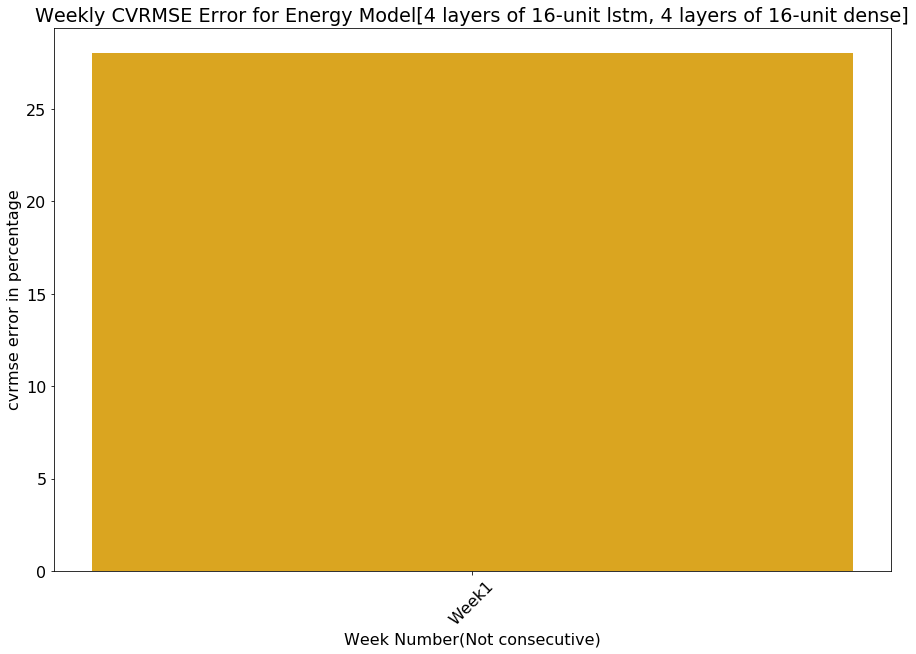

In [17]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)